# Visualization notebook

This notebook is meant for visualizing stuff and testing code. 

In [3]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
from pathlib import Path
from more_itertools import chunked
from dataclasses import dataclass
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
from gram2vec.featurizers import GrammarVectorizer
warnings.filterwarnings("ignore", category=FutureWarning)

# PAN 2022 Summary Stats & Visualizations


In [4]:
@dataclass
class Author:
    """
    Stores author information in an easy to work with format
    
    :param author_id: unique author id
    :param fixed_texts: list of author documents with regex fixes
    :param raw_texts: list of author documents without regex fixes
    :param discourse_types: list of discourse types
    
    Note: fixed_docs, raw_docs, and discourse_types are all 1 - 1 corresponding
    """
    author_id:str
    fixed_texts:list[str]
    raw_texts:list[str]
    discourse_types:list[str]
    
    def get_token_counts(self) -> list[int]:
        return [len(word_tokenize(author_doc)) for author_doc in self.fixed_texts]
    
    def get_total_docs(self) -> int:
        return len(self.fixed_texts)
    
    def count_dicourse_type(self, dtype:str) -> int:
        return Counter(self.discourse_types)[dtype]
        
def load_json(path:str) -> dict[str, list[dict]]:
    with open(path, "r") as fin:
        data = json.load(fin)
        return data

def extract_from_dict(author_entry:dict, to_extract:str) -> list[str]:
    return [entry[to_extract] for entry in author_entry]
    
def create_author_list(preprocessed_data:dict[str, list[dict]]) -> list[Author]:
    """
    Converts the preprocessed_data.json data into a list of Author objects
    """
    authors = []
    for author_id in preprocessed_data.keys():
        author_entry = preprocessed_data[author_id]
        fixed_texts = extract_from_dict(author_entry,"fixed_text")
        raw_texts = extract_from_dict(author_entry,"raw_text")
        discourse_types = extract_from_dict(author_entry,"discourse_type")
            
        authors.append(Author(author_id, fixed_texts, raw_texts, discourse_types))
        
    return authors

def get_doc_token_stats(authors:list[Author]) -> tuple[float, float]:
    """Gets the mean and std of tokens per document"""
    all_doc_token_counts = []
    for author in authors:
        all_doc_token_counts.extend(author.get_token_counts())
    return np.mean(all_doc_token_counts), np.std(all_doc_token_counts)
    
def make_author_df(authors:list[Author]) -> pd.DataFrame:
    
    author_maps = defaultdict(list)
    for author in authors:
        author_maps["author_id"].append(author.author_id)
        author_maps["total_token_count"].append(sum(author.get_token_counts()))
        author_maps["Total docs"].append(author.get_total_docs())
        author_maps["Emails"].append(author.count_dicourse_type("email"))
        author_maps["Memos"].append(author.count_dicourse_type("memo"))
        author_maps["Txt msgs"].append(author.count_dicourse_type("text_message"))
        author_maps["Essays"].append(author.count_dicourse_type("essay"))
        
    return pd.DataFrame(author_maps)


In [5]:

data = load_json("data/pan22/preprocessed/preprocessed_data.json")
all_authors = create_author_list(data)

avg_tokens_per_doc, std_tokens_per_doc = get_doc_token_stats(all_authors)

df = make_author_df(all_authors)

Text(0, 0.5, '# of authors')

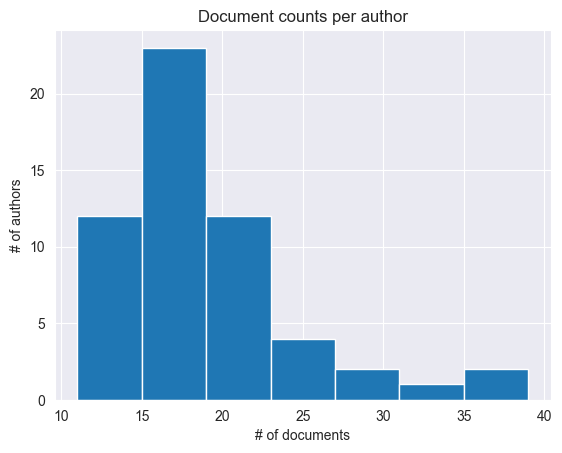

In [7]:

sns.set_style("darkgrid")
df["Total docs"].hist(bins=7)
plt.title("Document counts per author")
plt.xlabel("# of documents")
plt.ylabel("# of authors")


In [2]:
df = pd.read_csv("eval/results/pan_dev_bin_results.csv")

np.array(df["Accuracy"])

array([0.22857143, 0.51428571, 0.48571429, 0.54285714, 0.71428571,
       0.68571429, 0.71428571, 0.77142857])

## Dev bin visuals

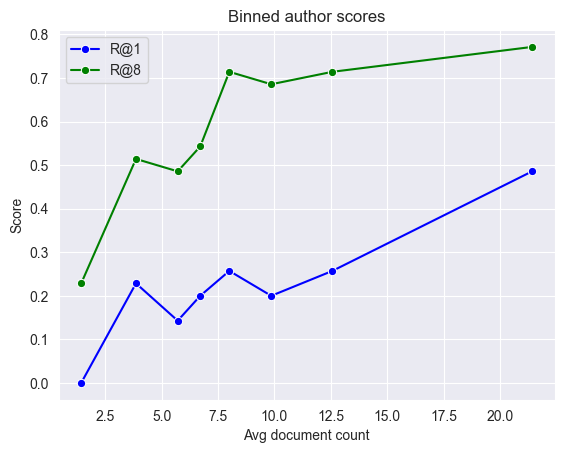

In [14]:
from data.scripts.pan_create_bins import get_train_authors_sorted_by_docfreq

def bin_authors(iterable) -> tuple[list[str], ...]:
    return tuple(chunked(iterable, 7)) 

def make_doc_avg_labels(sorted_dict):
       
       labels = []
       for bin in bin_authors(list(sorted_dict.values())):
              labels.append(round(np.mean(bin), 2))
       return labels

train_path = "eval/pan22_splits/knn/train.json"
train_authors_sorted = get_train_authors_sorted_by_docfreq(train_path)
labels = make_doc_avg_labels(train_authors_sorted)

# k = 6
r_at_1 = np.array([0., 0.22857143, 0.14285714, 0.2, 0.25714286,0.2, 0.25714286, 0.48571429])

r_at_8 = np.array([0.22857143, 0.51428571, 0.48571429, 0.54285714, 0.71428571,
       0.68571429, 0.71428571, 0.77142857])



df = pd.DataFrame({
       "Bin labels": labels,
       "R@1": r_at_1,
       "R@8": r_at_8
})

sns.set_style("darkgrid")


sns.lineplot(data=df, x="Bin labels", y="R@1",color="blue",marker="o", label="R@1")
sns.lineplot(data=df, x="Bin labels", y="R@8",color="green",marker="o", label="R@8")
plt.xlabel("Avg document count")
plt.ylabel("Score")
plt.title("Binned author scores")
plt.legend()



In [11]:
df

,Bin labels,R@1,R@8
0,1.43,0.000000,0.228571
1,3.86,0.228571,0.514286
2,5.71,0.142857,0.485714
3,6.71,0.200000,0.542857
4,8.00,0.257143,0.714286
5,9.86,0.200000,0.685714
6,12.57,0.257143,0.714286
7,21.43,0.485714,0.771429


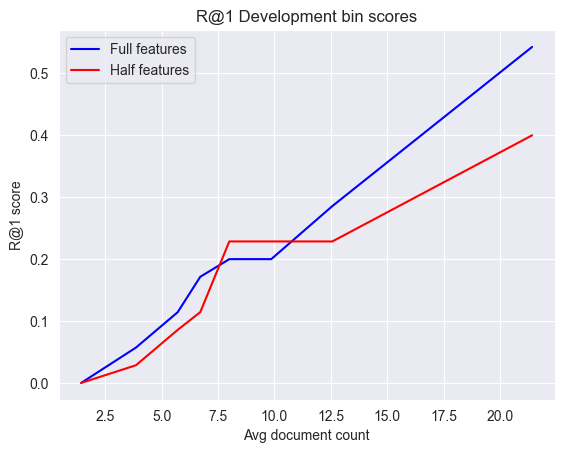

In [54]:
ALL_FEATS_ACCS = [0.0, 0.05714285714285714, 0.11428571428571428, 0.17142857142857143, 0.2, 0.2, 0.2857142857142857, 0.5428571428571428]
HALF_FEATS_ACCS = [0.0, 0.02857142857142857, 0.08571428571428572, 0.11428571428571428, 0.22857142857142856, 0.22857142857142856, 0.22857142857142856, 0.4]

old_df = pd.DataFrame(
    {"Full features": ALL_FEATS_ACCS,
     "Half features": HALF_FEATS_ACCS,
     "Bin labels":labels}
)


sns.lineplot(data=old_df, x="Bin labels", y="Full features",color="blue", label="Full features")
sns.lineplot(data=old_df, x="Bin labels", y="Half features", color="red", label="Half features")
plt.xlabel("Avg document count")
plt.ylabel("R@1 score")
plt.title("R@1 Development bin scores")
plt.legend()

plt.show()

# Discourse related stuff

In [14]:
def load_all_discourse_types(path:str) -> tuple[list,list,list]:
    """Loads the preprocessed data and sorts it by discourse type"""
    preprocessed = load_json(path)
    author_ids = preprocessed.keys()
    emails = []
    memos = []
    txt_msgs = []
    essays = []
    for author_id in author_ids:
        for author_entry in preprocessed[author_id]:
            dtype = author_entry["discourse_type"]
            fixed = author_entry["fixed_text"].split()
            
            if  dtype == "email":
                emails.append(fixed)
                
            if  dtype == "memo":
                memos.append(fixed)
                
            if  dtype == "text_message":
                txt_msgs.append(fixed)
                
            if  dtype == "essay":
                essays.append(fixed)
    return emails, memos, txt_msgs, essays
  
def get_avg_tokens(dtype:list[list[str]]) -> int:
    
    token_counts = []
    for tokens in dtype:
        token_counts.append(len(tokens))
    return np.mean(token_counts)
              
            
emails, memos, txt_msgs, essays = load_all_discourse_types("data/pan22/preprocessed/preprocessed_data.json")


print(get_avg_tokens(emails))
print(get_avg_tokens(memos))
print(get_avg_tokens(txt_msgs))
print(get_avg_tokens(essays))
    

331.5807086614173
182.10714285714286
109.21794871794872
412.86021505376345


In [ ]:
sns.set_style("darkgrid")

dtype_df = df[["Emails", "Txt msgs", "Essays", "Memos"]].sum()
dtype_df.plot.bar(color=["teal", "lightpink", "orange", "brown"])
plt.title("Discourse type counts")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.show()